In [1]:
import numpy as np
# import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import utils

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

from environment import RULEnvironment
from agent2 import MyAgent

from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras import Input
from keras.layers import Dense, Flatten

### Load and preprocess train data

In [2]:
# Config
figsize = (9, 3)

In [3]:
data_path = "./data"
data = utils.load_data(data_path)
data.head()

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD001,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,train_FD001,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,train_FD001,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,train_FD001,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,train_FD001,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [4]:
# Last column is the RUL (Label)
dt_in = list(data.columns[3:-1])
data[dt_in].describe()

,p1,p2,p3,s1,s2,s3,s4,s5,s6,s7,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,...,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000
mean,17.211973,0.410004,95.724344,485.840890,597.361022,1467.035653,1260.956434,9.894999,14.424935,359.729968,...,338.789821,2349.645243,8088.950972,9.054747,0.025185,360.698801,2273.754039,98.389146,25.942709,15.565700
std,16.527988,0.367938,12.359044,30.420388,42.478516,118.175261,136.300073,4.265554,6.443922,174.133835,...,164.193480,111.167242,80.623257,0.751581,0.004997,31.021430,142.513114,4.656270,11.691422,7.015067
min,-0.008700,-0.000600,60.000000,445.000000,535.480000,1242.670000,1023.770000,3.910000,5.670000,136.170000,...,128.310000,2027.570000,7845.780000,8.156300,0.020000,302.000000,1915.000000,84.930000,10.160000,6.010500
25%,0.001300,0.000200,100.000000,449.440000,549.960000,1357.360000,1126.830000,5.480000,8.000000,175.710000,...,164.790000,2387.970000,8070.530000,8.439250,0.020000,332.000000,2212.000000,100.000000,14.330000,8.601300
50%,19.998100,0.620000,100.000000,489.050000,605.930000,1492.810000,1271.740000,9.350000,13.660000,341.690000,...,321.690000,2388.070000,8118.590000,9.030100,0.030000,367.000000,2319.000000,100.000000,24.920000,14.953500
75%,35.001500,0.840000,100.000000,518.670000,642.340000,1586.590000,1402.200000,14.620000,21.610000,553.290000,...,521.340000,2388.160000,8139.410000,9.344200,0.030000,392.000000,2388.000000,100.000000,38.820000,23.294600
max,42.008000,0.842000,100.000000,518.670000,645.110000,1616.910000,1441.490000,14.620000,21.610000,570.810000,...,537.490000,2390.490000,8293.720000,11.066900,0.030000,400.000000,2388.000000,100.000000,39.890000,23.950500


In [5]:
data.describe()

,machine,cycle,p1,p2,p3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
count,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,...,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000
mean,370.270050,123.331338,17.211973,0.410004,95.724344,485.840890,597.361022,1467.035653,1260.956434,9.894999,...,2349.645243,8088.950972,9.054747,0.025185,360.698801,2273.754039,98.389146,25.942709,15.565700,122.331338
std,203.411987,83.538146,16.527988,0.367938,12.359044,30.420388,42.478516,118.175261,136.300073,4.265554,...,111.167242,80.623257,0.751581,0.004997,31.021430,142.513114,4.656270,11.691422,7.015067,83.538146
min,1.000000,1.000000,-0.008700,-0.000600,60.000000,445.000000,535.480000,1242.670000,1023.770000,3.910000,...,2027.570000,7845.780000,8.156300,0.020000,302.000000,1915.000000,84.930000,10.160000,6.010500,0.000000
25%,196.000000,57.000000,0.001300,0.000200,100.000000,449.440000,549.960000,1357.360000,1126.830000,5.480000,...,2387.970000,8070.530000,8.439250,0.020000,332.000000,2212.000000,100.000000,14.330000,8.601300,56.000000
50%,381.000000,114.000000,19.998100,0.620000,100.000000,489.050000,605.930000,1492.810000,1271.740000,9.350000,...,2388.070000,8118.590000,9.030100,0.030000,367.000000,2319.000000,100.000000,24.920000,14.953500,113.000000
75%,547.000000,173.000000,35.001500,0.840000,100.000000,518.670000,642.340000,1586.590000,1402.200000,14.620000,...,2388.160000,8139.410000,9.344200,0.030000,392.000000,2388.000000,100.000000,38.820000,23.294600,172.000000
max,709.000000,543.000000,42.008000,0.842000,100.000000,518.670000,645.110000,1616.910000,1441.490000,14.620000,...,2390.490000,8293.720000,11.066900,0.030000,400.000000,2388.000000,100.000000,39.890000,23.950500,542.000000


In [6]:
# Check for null-values
data[dt_in].isnull().any().any()

# No null values

False

In [7]:
# Standardize all the daa-columns
data_sv = data.copy()
data_sv[dt_in] = (data_sv[dt_in] - data_sv[dt_in].mean()) / data_sv[dt_in].std()
data_sv.head()

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD001,1,1,-1.041426,-1.115415,0.345954,1.079181,1.046623,1.037987,1.024530,...,0.345198,0.616063,-0.845214,0.963586,1.009019,0.801652,0.345954,1.121959,1.119490,191
1,train_FD001,1,2,-1.041268,-1.115143,0.345954,1.079181,1.054391,1.055926,1.043166,...,0.345648,0.527627,-0.828849,0.963586,1.009019,0.801652,0.345954,1.116827,1.120146,190
2,train_FD001,1,3,-1.041644,-1.113512,0.345954,1.079181,1.059100,1.023517,1.050943,...,0.345288,0.549209,-0.847476,0.963586,0.944547,0.801652,0.345954,1.112550,1.108828,189
3,train_FD001,1,4,-1.041341,-1.114327,0.345954,1.079181,1.059100,0.979514,1.033848,...,0.345738,0.556651,-0.913470,0.963586,1.009019,0.801652,0.345954,1.106563,1.113061,188
4,train_FD001,1,5,-1.041498,-1.114871,0.345954,1.079181,1.059570,0.980022,1.065763,...,0.345378,0.556279,-0.832042,0.963586,1.041254,0.801652,0.345954,1.108273,1.117409,187


In [8]:
data_sv_dict = utils.split_by_field(data_sv, field='src')
print('{{{}}}'.format(', '.join(f'{k}: ...' for k in data_sv_dict.keys())))

{train_FD001: ..., train_FD002: ..., train_FD003: ..., train_FD004: ...}


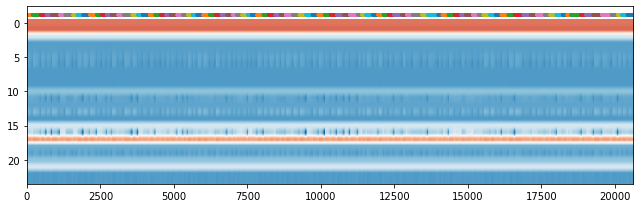

In [9]:
tmp = data_sv_dict['train_FD001']
utils.plot_dataframe(tmp[dt_in], labels=tmp['machine'], figsize=figsize)

### Make environment

In [10]:
env = RULEnvironment(data_sv, dt_in)

/usr/local/lib/python3.9/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [11]:
states = env.observation_space.shape
actions = env.action_space.n
states

(24,)

### Build model

In [12]:
def build_model(states, actions):
    model = Sequential()
    model.add(Input((1,24))) 
    # model.add(Flatten(input_shape=(1,24)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Flatten())
    model.add(Dense(2, activation='linear'))
    return model

In [13]:
model = build_model(states, actions)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 64)             1600      
                                                                 
 dense_1 (Dense)             (None, 1, 64)             4160      
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 5,890
Trainable params: 5,890
Non-trainable params: 0
_________________________________________________________________


### Build agent

In [14]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = MyAgent(model=model, memory=memory, policy=policy, nb_actions=actions, nb_steps_warmup=1000, target_model_update=1e-2)
    return dqn

In [15]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

/usr/local/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-01-28 18:19:51.953468: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Train

In [16]:
nb_episodes = data_sv['machine'].max()
nb_steps = len(data_sv)

In [17]:
dqn.fit(env, nb_steps=50000, nb_episodes=nb_steps, nb_max_episode_steps=None, visualize=False, verbose=1)

Training for 50000 steps ...
My methode is startn
e: 1 i 1
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 15:58 - reward: 1.0000e: 2 i 1
e: 3 i 1
e: 4 i 1
e: 5 i 1
e: 6 i 1
   10/10000 [..............................] - ETA: 56s - reward: 1.0000  e: 7 i 1
e: 8 i 1
e: 9 i 1
e: 10 i 1
e: 11 i 1
e: 12 i 1
   18/10000 [..............................] - ETA: 1:05 - reward: 1.0000

/usr/local/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


e: 13 i 1
e: 14 i 1
e: 15 i 1
e: 16 i 1
   22/10000 [..............................] - ETA: 1:18 - reward: 1.0000e: 17 i 1
e: 18 i 1
e: 19 i 1
e: 20 i 1
e: 21 i 1
   29/10000 [..............................] - ETA: 1:16 - reward: 1.0000e: 22 i 1
e: 23 i 1
e: 24 i 1
e: 25 i 1
e: 26 i 1
e: 27 i 1
   36/10000 [..............................] - ETA: 1:16 - reward: 1.0000e: 28 i 1
e: 29 i 1
e: 30 i 1
   45/10000 [..............................] - ETA: 1:12 - reward: 1.0000e: 31 i 1
e: 32 i 1
e: 33 i 1
e: 34 i 1
e: 35 i 1
e: 36 i 1
   53/10000 [..............................] - ETA: 1:11 - reward: 1.0000e: 37 i 1
e: 38 i 1
e: 39 i 1
e: 40 i 1
e: 41 i 1
e: 42 i 1
   64/10000 [..............................] - ETA: 1:07 - reward: 1.0000e: 43 i 1
e: 44 i 1
e: 45 i 1
e: 46 i 1
   72/10000 [..............................] - ETA: 1:07 - reward: 1.0000e: 47 i 1
e: 48 i 1
e: 49 i 1
   78/10000 [..............................] - ETA: 1:09 - reward: 1.0000e: 50 i 1
e: 51 i 1
e: 52 i 1
e: 53 i 1
e: 54 

### Test

In [ ]:
data_path = "./data"
data_test = utils.load_data(data_path, test=True)
dt_in_test = list(data_test.columns[3:-1])
data_test.head()

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,test_FD001,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,30
1,test_FD001,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,29
2,test_FD001,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,28
3,test_FD001,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,27
4,test_FD001,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,26


In [ ]:
# Check for null-values
data_test[dt_in_test].isnull().any().any()

# No null values

False

In [ ]:
# Standardize all the daa-columns
data_sv_test = data_test.copy()
data_sv_test[dt_in_test] = (data_sv_test[dt_in_test] - data_sv_test[dt_in_test].mean()) / data_sv_test[dt_in_test].std()
data_sv_test.head()

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,test_FD001,1,1,-1.043035,-1.115489,0.344854,1.080583,1.080980,1.022865,1.038612,...,0.344653,0.517533,-0.857030,0.992312,1.031664,0.802698,0.344854,1.103335,1.111456,30
1,test_FD001,1,2,-1.043337,-1.117119,0.344854,1.080583,1.050106,1.049677,1.018056,...,0.344924,0.695733,-0.890302,0.992312,1.063992,0.802698,0.344854,1.117009,1.114034,29
2,test_FD001,1,3,-1.043156,-1.116032,0.344854,1.080583,1.067782,1.036865,1.061673,...,0.344653,0.575160,-0.805052,0.992312,1.063992,0.802698,0.344854,1.122137,1.117595,28
3,test_FD001,1,4,-1.042920,-1.116304,0.344854,1.080583,1.067310,1.012938,1.099100,...,0.344833,0.610622,-0.875069,0.992312,0.999335,0.802698,0.344854,1.115300,1.111484,27
4,test_FD001,1,5,-1.043089,-1.116304,0.344854,1.080583,1.068960,1.038986,1.065946,...,0.344653,0.568067,-0.859836,0.992312,0.967007,0.802698,0.344854,1.114445,1.117082,26


In [ ]:
data_test

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,test_FD001,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,30
1,test_FD001,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,29
2,test_FD001,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,28
3,test_FD001,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,27
4,test_FD001,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41209,test_FD004,707,277,41.9991,0.8401,100.0,445.00,550.30,1364.40,1129.17,...,2388.50,8112.61,9.4427,0.02,331,2212,100.0,10.53,6.2620,4
41210,test_FD004,707,278,20.0026,0.7005,100.0,491.19,608.00,1494.75,1260.88,...,2388.33,8086.83,9.2772,0.02,366,2324,100.0,24.33,14.6486,3
41211,test_FD004,707,279,34.9988,0.8413,100.0,449.44,555.92,1370.65,1130.97,...,2388.64,8100.84,9.3982,0.02,336,2223,100.0,14.69,8.8389,2
41212,test_FD004,707,280,20.0027,0.7000,100.0,491.19,608.19,1489.11,1256.25,...,2388.37,8085.24,9.2727,0.03,366,2324,100.0,24.44,14.6887,1


In [ ]:
env_test = RULEnvironment(data_sv_test, dt_in_test)

/usr/local/lib/python3.9/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
nb_episodes = data_sv_test['machine'].max()

In [ ]:
scores = dqn.test(env_test, nb_episodes=nb_episodes, visualize=False)
print(np.mean(scores.history['episode_reward']))

Testing for 707 episodes ...
e: 1 i 1
Episode 1: reward: -471.000, steps: 30
e: 2 i 1
Episode 2: reward: -453.000, steps: 48
e: 3 i 1
Episode 3: reward: -376.000, steps: 125
e: 4 i 1
Episode 4: reward: -396.000, steps: 105
e: 5 i 1
Episode 5: reward: -404.000, steps: 97
e: 6 i 1
Episode 6: reward: -397.000, steps: 104
e: 7 i 1
Episode 7: reward: -342.000, steps: 159
e: 8 i 1
Episode 8: reward: -336.000, steps: 165
e: 9 i 1
Episode 9: reward: -447.000, steps: 54
e: 10 i 1
Episode 10: reward: -310.000, steps: 191
e: 11 i 1
Episode 11: reward: -419.000, steps: 82
e: 12 i 1
Episode 12: reward: -285.000, steps: 216
e: 13 i 1
Episode 13: reward: -307.000, steps: 194
e: 14 i 1
Episode 14: reward: -456.000, steps: 45
e: 15 i 1
Episode 15: reward: -426.000, steps: 75
e: 16 i 1
Episode 16: reward: -389.000, steps: 112
e: 17 i 1
Episode 17: reward: -337.000, steps: 164
e: 18 i 1
Episode 18: reward: -369.000, steps: 132
e: 19 i 1
Episode 19: reward: -367.000, steps: 134
e: 20 i 1
Episode 20: rewar